In [ ]:
import torch 
import torchvision
from torchvision import transforms
from torch import nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
class Discriminator_Linear(nn.Module):
  def __init__(self,in_features):
    super(Discriminator_Linear,self).__init__()
    self.Linear1= nn.Linear(in_features,128)
    self.Leaky_relu=nn.LeakyReLU(0.1)
    self.Linear2= nn.Linear(128,1)
    self.Sigmoid=nn.Sigmoid()
    # self.disc_model=nn.Sequential(
    #     *[
    #      nn.Linear(in_features,128),
    #      nn.LeakyReLU(0.1),
    #      nn.Linear(128,1),
    #      nn.Sigmoid(),
    #     ]
    # )

  def forward(self,x):
    x=self.Leaky_relu( self.Linear1(x))
    return self.Sigmoid( self.Linear2(x))


In [ ]:
class Generator_Linear(nn.Module):
  def __init__(self,z_dim,in_features):
    super(Generator_Linear,self).__init__()
    self.Linear1= nn.Linear(z_dim,256)
    self.Leaky_relu=nn.LeakyReLU(0.1)
    self.Linear2= nn.Linear(256,in_features)
    self.tanh=nn.Tanh()
    # self.Gen_model=nn.Sequential(
    #     *[
    #      nn.Linear(z_dim,256),
    #      nn.LeakyReLU(0.1),
    #      nn.Linear(256,in_features),
    #      nn.Tanh(),
    #     ]
    # )

  def forward(self,x):
    x=self.Leaky_relu( self.Linear1(x))
    return self.tanh( self.Linear2(x))

In [ ]:
class Generator_Conv(nn.Module):
  def __init__(self,z_dim,image_dim):
    super(Generator_Conv,self).__init__()
    self.Linear1=nn.Linear(z_dim,2*2*1024)
    self.conv1=nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1)
    self.BatchNorm1=nn.BatchNorm2d(512)
    self.conv2=nn.ConvTranspose2d(512,256,kernel_size=4,stride=1,padding=0)
    self.BatchNorm2=nn.BatchNorm2d(256)
    self.conv3=nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)
    self.BatchNorm3=nn.BatchNorm2d(128)
    self.conv4=nn.ConvTranspose2d(128,image_dim,kernel_size=4,stride=2,padding=1)
    self.BatchNorm4=nn.BatchNorm2d(image_dim)
    self.relu=nn.ReLU()
    self.tanh=nn.Tanh()
  
  def forward(self,x):
    x=self.Linear1(x)
    x=x.view(-1,1024,2,2)
    x=self.relu(self.BatchNorm1(self.conv1(x)))
    x=self.relu(self.BatchNorm2(self.conv2(x)))
    x=self.relu(self.BatchNorm3(self.conv3(x)))
    x=self.tanh(self.BatchNorm4(self.conv4(x)))
    return x
    

In [ ]:
class Discriminator_Conv(nn.Module):
  def __init__(self,image_dim):
    super(Discriminator_Conv,self).__init__()
    self.conv1=nn.Conv2d(image_dim,64,kernel_size=3,stride=2,padding=1)
    self.BatchNorm1=nn.BatchNorm2d(64)
    self.conv2=nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1)
    self.BatchNorm2=nn.BatchNorm2d(128)
    self.conv3=nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1)
    self.BatchNorm3=nn.BatchNorm2d(256)
    self.conv4=nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1)
    self.BatchNorm4=nn.BatchNorm2d(512)
    self.Linear1=nn.Linear((2*2*512),1)
    self.relu=nn.LeakyReLU(negative_slope=0.01)
    self.sigmoid=nn.Sigmoid()
  
  def forward(self,x):
    x=self.relu(self.BatchNorm1(self.conv1(x)))
    x=self.relu(self.BatchNorm2(self.conv2(x)))
    x=self.relu(self.BatchNorm3(self.conv3(x)))
    x=self.relu(self.BatchNorm4(self.conv4(x)))
    x=torch.flatten(x,start_dim=1)
    
    return self.sigmoid(self.Linear1(x))

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
lr=0.0003
z_dim=100
image_dim=1
batch_size=128
number_of_epochs=10

In [ ]:
# disc_=Discriminator_Linear(image_dim).to(device)
# gen_=Generator_Linear(z_dim,image_dim).to(device)

In [ ]:
disc_=Discriminator_Conv(image_dim).to(device)
gen_=Generator_Conv(z_dim,image_dim).to(device)

In [ ]:
gen_

Generator_Conv(
  (Linear1): Linear(in_features=100, out_features=4096, bias=True)
  (conv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BatchNorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
  (BatchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BatchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BatchNorm4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [ ]:
disc_


Discriminator_Conv(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (BatchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (BatchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (BatchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (BatchNorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Linear1): Linear(in_features=2048, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

In [ ]:
from torchvision.transforms.transforms import Resize
transform=transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
    ]
)

In [ ]:
dataset=datasets.MNIST("/dataset",train=True,transform=transform,download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/train-images-idx3-ubyte.gz to /dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /dataset/MNIST/raw



In [ ]:
dataset_loader=DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [ ]:
disc_optimize=torch.optim.Adam(disc_.parameters(),lr=lr,betas=(0.5,0.99))
gen_optimize=torch.optim.Adam(gen_.parameters(),lr=lr,betas=(0.5,0.99))
criterion=nn.BCELoss()

In [ ]:
# writer_fake=SummaryWriter("runs/MNIST/fake")
# writer_real=SummaryWriter("runs/MNIST/real")
# step=0

In [ ]:
steps=0
for num_ in range(number_of_epochs):
  for batch_idx, (real,_) in enumerate(dataset_loader):
    # real=real.view(-1,784).to(device)
    real=real.to(device)
    noise=torch.randn((real.shape[0],z_dim)).to(device)
    fake_image=gen_(noise)
    output_real=disc_(real).view(-1)
    lossD_real=criterion(output_real,torch.ones_like(output_real))
    output_fake=disc_(fake_image).view(-1)
    lossD_fake=criterion(output_fake,torch.zeros_like(output_fake))
    lossD_=(lossD_real+lossD_fake)/2
    disc_.zero_grad()
    lossD_.backward(retain_graph=True)
    disc_optimize.step()
    
    output_fake=disc_(fake_image).view(-1)
    lossG_fake=criterion(output_fake,torch.ones_like(output_fake))
    gen_.zero_grad()
    lossG_fake.backward(retain_graph=True)
    gen_optimize.step()
    if batch_idx==0:
      print("loss Value for Genrator",lossG_fake)
      with torch.no_grad():
        # real_data=real.reshape(-1,1,28,28)
        # fake_data=fake_image.reshape(-1,1,28,28)
        # img_grid_fake=torchvision.utils.make_grid(real,normalize=True)
        # img_grid_real=torchvision.utils.make_grid(real_data,normalize=True)
        # writer_real.add_image("real Image",img_grid_real,global_step=steps)
        # writer_fake.add_image("fake Image",img_grid_fake,global_step=steps)
        steps+=1


loss Value for Genrator tensor(1.3089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


KeyboardInterrupt: ignored

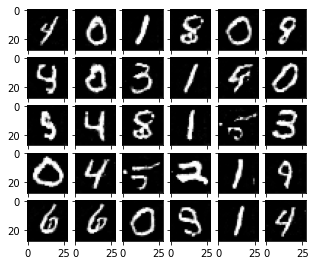

In [ ]:
noise=torch.randn((30,z_dim)).to(device)
output=gen_(noise)
output_image=output.detach().view(-1,28,28)
output_image=list(output_image.cpu().numpy())

# fig = plt.figure(figsize=(5,5))
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(5, 6),  # creates 2x2 grid of axes
#                  axes_pad=0.1,  # pad between axes in inch.
#                  )

# # for ax, im in zip(grid, output_image):
# #     # Iterating over the grid returns the Axes.
# #     ax.imshow(im,cmap="gray")
# # plt.show()

In [ ]:
torch.save(gen_.state_dict(), "./generator.pth")

In [ ]:
output_image.shape

torch.Size([28, 28])